# Importing libraries

In [ ]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
print(tf.__version__)

2.3.0


In [ ]:
import warnings
warnings.filterwarnings('ignore')

#Function to add Noise

In [ ]:
class Noise:
  def addNoise(input_img):
    mean = 0
    stdv = 20
    noise = np.random.randint(mean, stdv, input_img.shape)
    noisy_img = input_img + noise
    noisy_img = np.clip(noisy_img, 0.,255.)
    return noisy_img

#Dataset input pipeline

In [ ]:
#dataloader
from glob import glob
AUTOTUNE = tf.data.experimental.AUTOTUNE

class DataLoader:

  def __init__(self, images, img_size, batch_size=8, buffer_size=1024):
    self.images = images
    self.img_size = img_size
    self.batch_size = batch_size
    self.buffer_size = buffer_size

  def __len__(self):
    return len(self.images)

  @staticmethod
  def resNormImg(image, img_size):
    res_img = tf.image.resize(image, [img_size, img_size], 'bicubic')
    return res_img

  def map_function(self, image_file):
    image = tf.cast(image_file, dtype=tf.float32)
    print(image.shape)
    image.set_shape([self.img_size, self.img_size])
    truth = image/255.0
    img = Noise.addNoise(image)/255.0
    return img, truth


  def make_dataset(self):
    dataset = tf.data.Dataset.from_tensor_slices(self.images)
    dataset = dataset.shuffle(self.buffer_size, seed=2)
    dataset = dataset.map(
        self.map_function,
        num_parallel_calls=AUTOTUNE
    )
    dataset = dataset.batch(self.batch_size, drop_remainder=True)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

#Download MNIST

In [ ]:
from tensorflow.keras.datasets import mnist
(x_train, _), (x_test, _) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
img_size = 28
n_ch = 1
batch_size = 32
buf_size = 1024

In [ ]:
dataloader = DataLoader(x_train, img_size, batch_size, buf_size)
print(dataloader.__len__())

60000


255.0
(28, 28)
{}
{0: 618, 1: 2, 2: 3, 3: 1, 9: 1, 11: 3, 14: 1, 16: 2, 18: 5, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 30: 1, 35: 1, 36: 1, 39: 2, 43: 1, 45: 1, 46: 1, 49: 1, 55: 1, 56: 1, 64: 2, 66: 1, 70: 1, 78: 1, 80: 2, 81: 2, 82: 2, 90: 1, 93: 2, 94: 1, 107: 1, 108: 1, 114: 1, 119: 1, 126: 1, 127: 1, 130: 1, 132: 1, 133: 1, 135: 1, 136: 2, 139: 1, 148: 1, 150: 1, 154: 3, 156: 1, 160: 1, 166: 1, 170: 1, 171: 1, 172: 2, 175: 1, 182: 2, 183: 1, 186: 1, 187: 1, 190: 2, 195: 2, 198: 2, 201: 1, 205: 1, 207: 1, 212: 1, 213: 1, 219: 2, 221: 1, 225: 2, 226: 1, 229: 1, 238: 1, 240: 1, 241: 2, 242: 1, 244: 1, 247: 2, 249: 2, 250: 1, 251: 1, 252: 1, 253: 54, 255: 1}


True

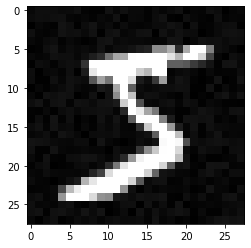

In [ ]:
test_img = x_train[0]
ns = Noise.addNoise(test_img)
print(ns.shape)

In [ ]:
dataset = dataloader.make_dataset()
dataset

(28, 28)


<PrefetchDataset shapes: ((32, 28, 28), (32, 28, 28)), types: (tf.float32, tf.float32)>

In [ ]:
print(dataset.take(15))

<TakeDataset shapes: ((32, 28, 28), (32, 28, 28)), types: (tf.float32, tf.float32)>


#Defining the Downsample and Upsample layers

In [ ]:
def downsample(filters, size, stride):
  conv = tf.keras.layers.Conv2D(filters, size, activation='relu',strides=stride, padding='same')
  return conv
  
def upsample(filters, size, stride):
  deconv = tf.keras.layers.Conv2DTranspose(filters, size, activation='relu',strides=stride, padding='same')
  return deconv

#Defining Model parameters

In [ ]:
sgd = tf.keras.optimizers.SGD
adam = tf.keras.optimizers.Adam
rmsp = tf.keras.optimizers.RMSprop
pixel_mse = 'mean_squared_error'
lr = 0.001

#Building the model

In [ ]:
def DenoiseNet(input_tensor):
  input = tf.keras.layers.Input(shape=input_tensor)
  down_stack = [
               downsample(64, 4, 1), #(bs,28,28,64)
               downsample(64, 4, 2), #(bs,14,14,64)
               downsample(128, 4, 2), #(bs,7,7,128)
               ]

  up_stack = [
             upsample(128, 4, 1), #(bs,7,7,128)
             upsample(64, 4, 2), #(bs,14,14,64)
             upsample(64, 4, 2), #(bs,28,28,64)
             ]


  dsc = []
  x = input
  output = upsample(n_ch, 4, 1)

  for layer in down_stack:
    x = layer(x)
    dsc.append(x)

  dsc = reversed(dsc)

  for layer, skip_conn in zip(up_stack, dsc):
    x = layer(x)
    x = tf.keras.layers.Add()([x, skip_conn])

  x = output(x)

  return tf.keras.Model(inputs=input, outputs=x)

#Structural Similarity Index Function

In [ ]:
def ssim(y_true, y_pred):
  y_true = (y_true + 1) / 2
  y_pred = (y_pred + 1)/ 2
  ssim = tf.image.ssim(y_true, y_pred, 1.0)
  return ssim

#Peak Signal to Noise Ratio Function

In [ ]:
def psnr(y_true, y_pred, max_val=255.0):
  y_true = (y_true + max_val) / 2
  y_pred = (y_pred + max_val) / 2
  psnr = tf.image.psnr(y_true, y_pred, max_val)
  return psnr

#Compiling and displaying the model

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 28, 28, 64)   1088        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 14, 14, 64)   65600       conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 7, 7, 128)    131200      conv2d_26[0][0]                  
______________________________________________________________________________________

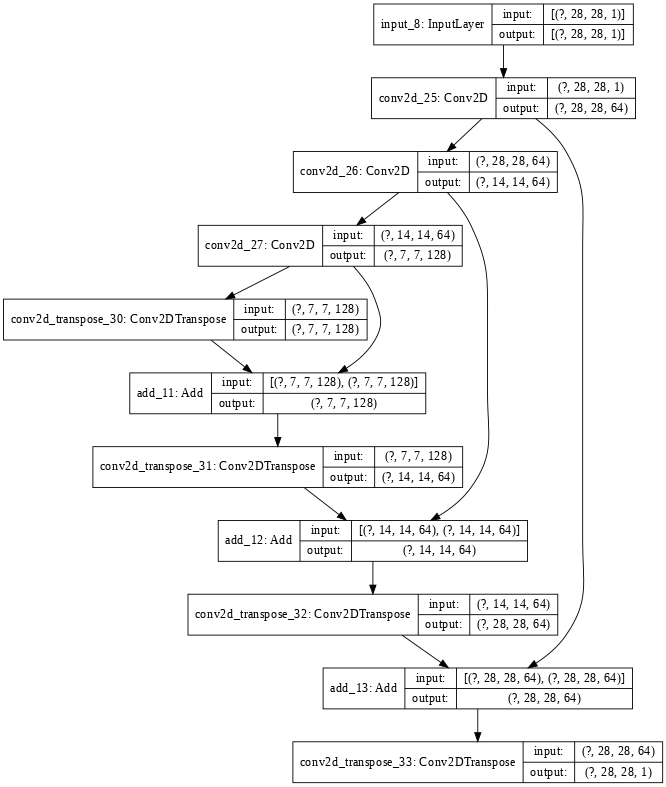

In [ ]:
model = DenoiseNet((img_size,img_size, n_ch))
model.compile(loss=pixel_mse, optimizer=adam(lr), metrics=['accuracy', ssim, psnr])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
model_used = 'DenoiseNet_MNIST'

In [ ]:
print(dataloader.__len__()//dataloader.batch_size)

1875


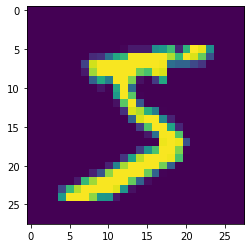

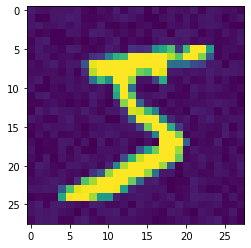

In [ ]:
x_train = x_train.astype(np.float32)
x_train_noisy = Noise.addNoise(x_train)
plt.imshow(x_train[0])
plt.show()
plt.imshow(x_train_noisy[0])
plt.show()

In [ ]:
model.fit(dataset,
          epochs=2,
          verbose=1,
          steps_per_epoch=dataloader.__len__()//dataloader.batch_size
)

Epoch 1/2
1875/1875 [==============================] - 15s 8ms/step - loss: 2.7189e-04 - accuracy: 0.8155 - ssim: 0.9979 - psnr: 48.7588
Epoch 2/2
1875/1875 [==============================] - 15s 8ms/step - loss: 2.7736e-05 - accuracy: 0.8155 - ssim: 0.9998 - psnr: 51.7902


#Model Training

In [ ]:
model.fit(x_train_noisy,
          x_train,
          epochs=10,
          verbose=1,
          steps_per_epoch=dataloader.__len__()//dataloader.batch_size
)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 22.6865 - accuracy: 0.7826 - ssim: 0.9433 - psnr: 45.8280
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 5.0914 - accuracy: 0.7988 - ssim: 0.9755 - psnr: 47.0970
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.9489 - accuracy: 0.8001 - ssim: 0.9811 - psnr: 47.2211
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.8418 - accuracy: 0.8008 - ssim: 0.9835 - psnr: 47.3155
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.8185 - accuracy: 0.8012 - ssim: 0.9857 - psnr: 47.3367
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.7091 - accuracy: 0.8016 - ssim: 0.9875 - psnr: 47.4327
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.6943 - accuracy: 0.8018 - ssim: 0.9891 - psnr: 47.4473
Epoch 8/10
1875/1875 [==============================] - 15s 8

In [ ]:
model.save(model_used+'.h5')

In [ ]:
dependencies = {'ssim': ssim, 'psnr': psnr}
model = load_model(model_used+'.h5', compile=True,custom_objects= dependencies)
#model.compile(loss=pixel_mse, optimizer=adam(lr), metrics=['accuracy', ssim])
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 28, 28, 64)   1088        input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 14, 14, 64)   65600       conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 7, 7, 128)    131200      conv2d_26[0][0]                  
______________________________________________________________________________________

In [ ]:
model.fit(dataset,
          epochs=10,
          verbose=1,
          steps_per_epoch=dataloader.__len__()//dataloader.batch_size
)

In [ ]:
model.fit(x_train_noisy,
          x_train,
          epochs=10,
          verbose=1,
          steps_per_epoch=dataloader.__len__()//dataloader.batch_size
)

Epoch 1/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.4201 - accuracy: 0.8029 - ssim: 0.9946 - psnr: 47.7034
Epoch 2/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.4223 - accuracy: 0.8029 - ssim: 0.9947 - psnr: 47.7023
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.3975 - accuracy: 0.8029 - ssim: 0.9949 - psnr: 47.7264
Epoch 4/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.3727 - accuracy: 0.8030 - ssim: 0.9948 - psnr: 47.7501
Epoch 5/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.3706 - accuracy: 0.8030 - ssim: 0.9950 - psnr: 47.7526
Epoch 6/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.3705 - accuracy: 0.8030 - ssim: 0.9951 - psnr: 47.7531
Epoch 7/10
1875/1875 [==============================] - 15s 8ms/step - loss: 4.3309 - accuracy: 0.8030 - ssim: 0.9952 - psnr: 47.7918
Epoch 8/10
1875/1875 [==============================] - 15s 8m

#Visualising the intermediate layers

(28, 28)


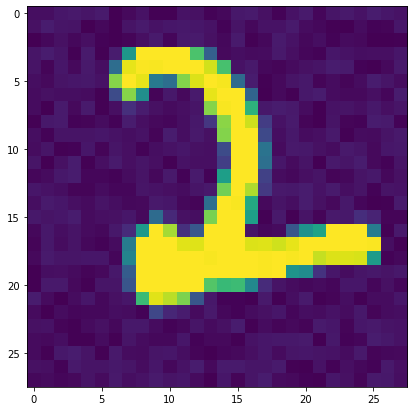

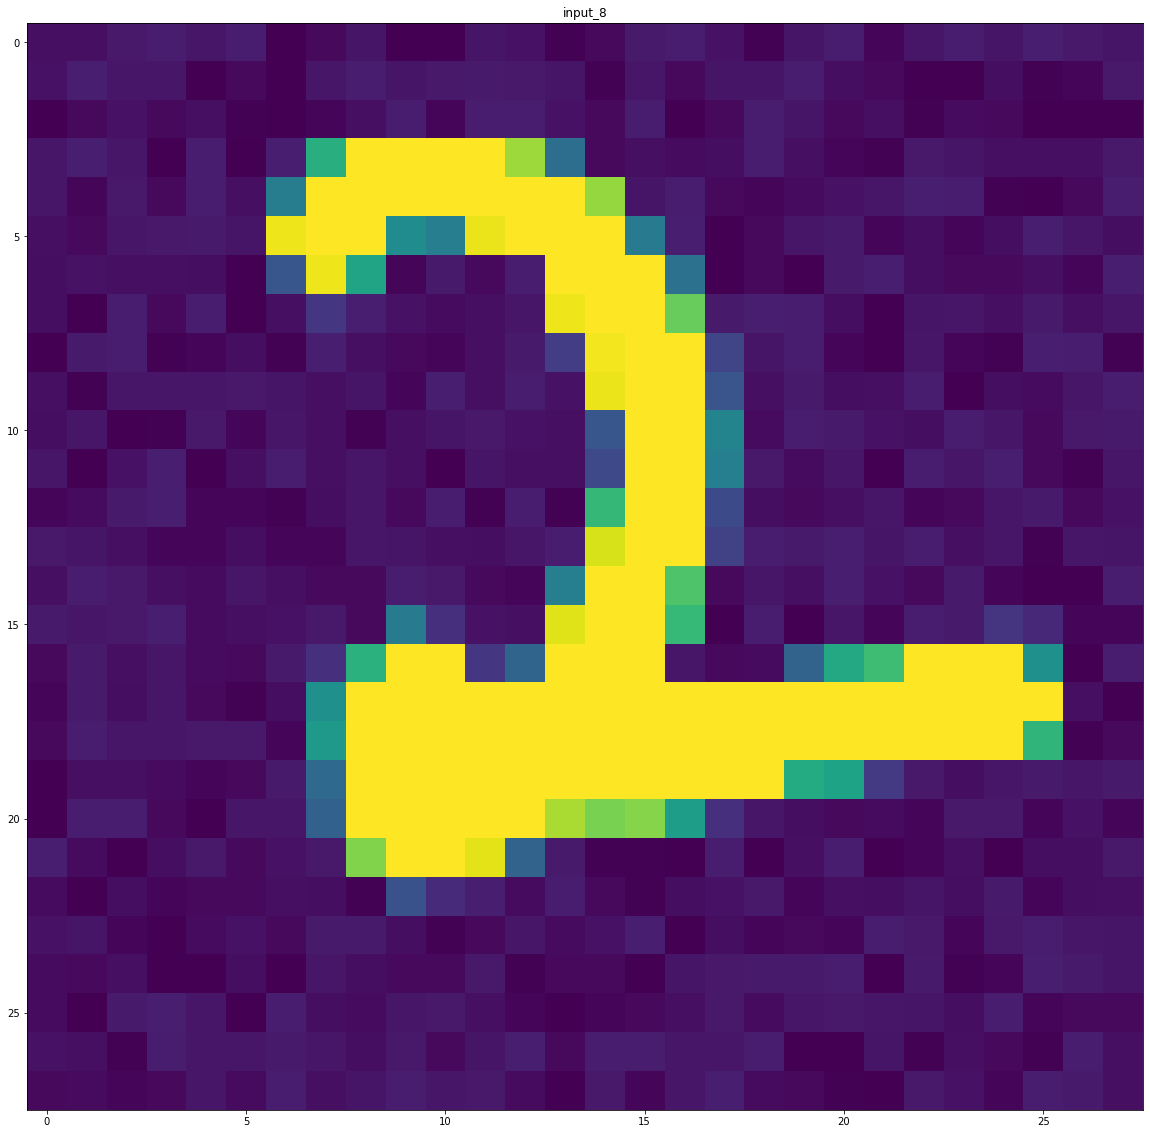

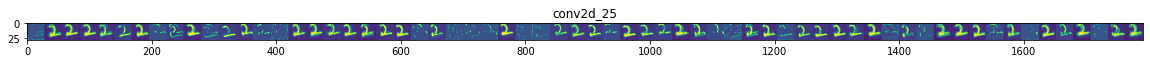

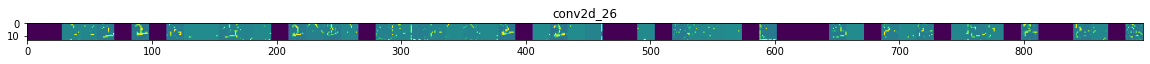

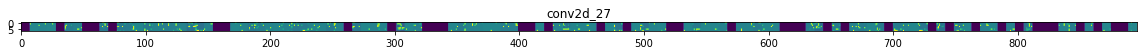

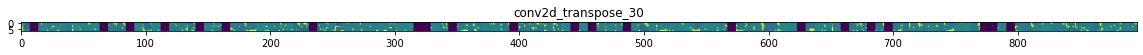

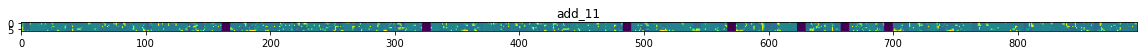

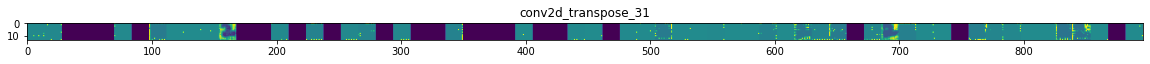

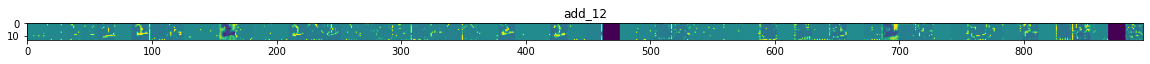

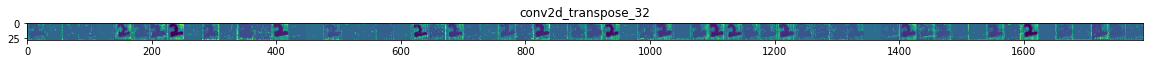

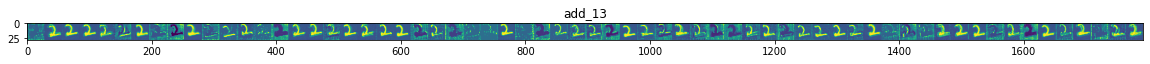

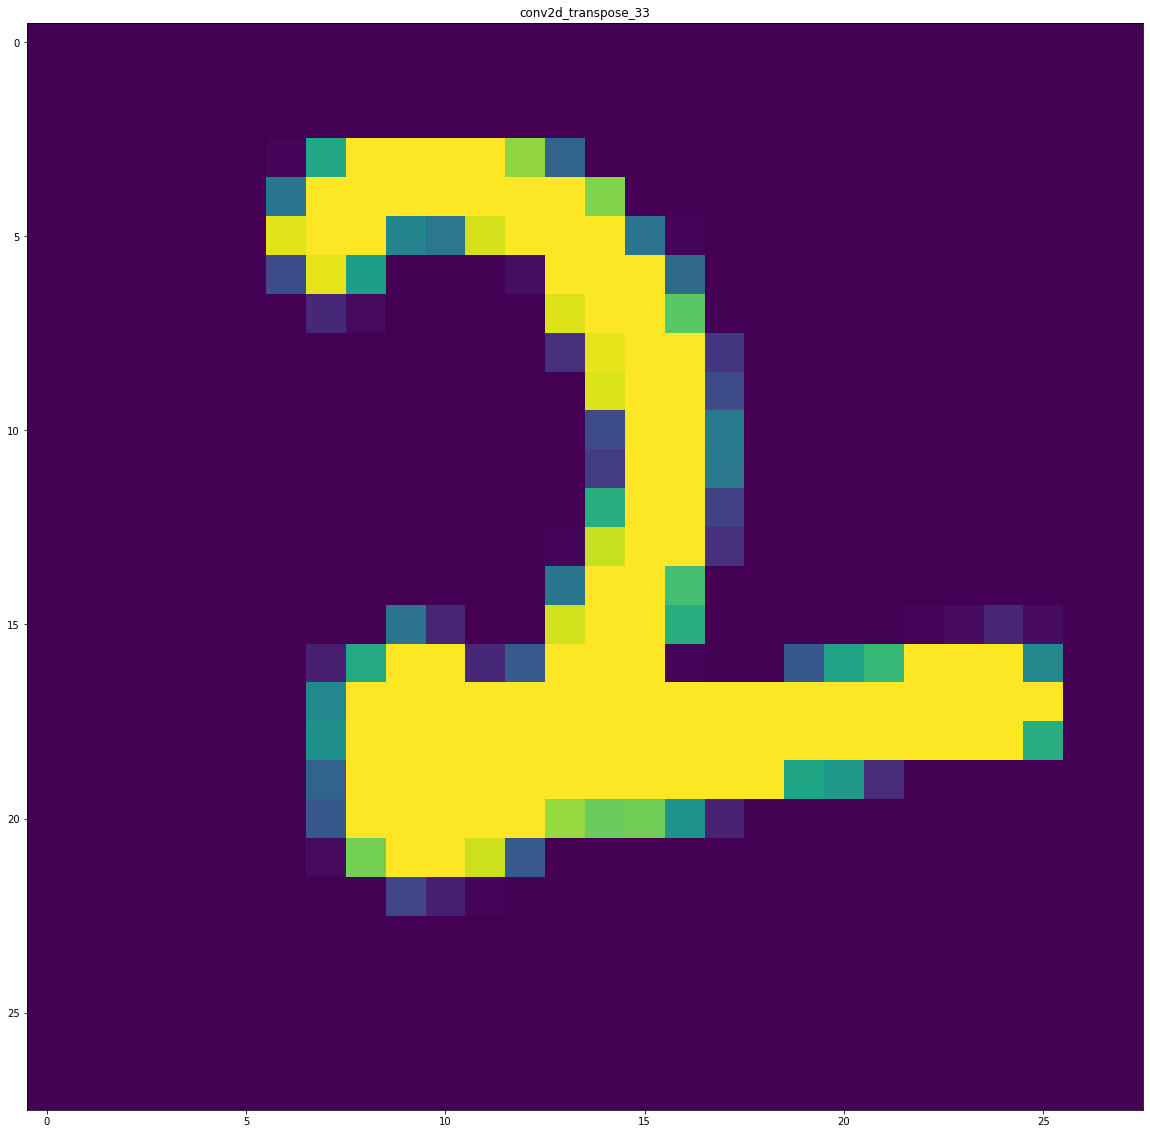

In [ ]:
successive_outputs = [layer.output for layer in model.layers]
visualization_model = Model(inputs = model.input, outputs = successive_outputs)
img = random.choice(x_train_noisy)
x = img
print(x.shape)
plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.show()
x = x.reshape((1,) + x.shape)

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    n_features = feature_map.shape[-1]

    size = feature_map.shape[1]
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    if layer_name == 'input_5':
      img_b = display_grid[:,:img_size]
      img_g = display_grid[:,img_size:2*img_size]
      img_r = display_grid[:,2*img_size:]
      print(img_b.shape, img_g.shape, img_r.shape)
      rgb = img
      plt.imshow(rgb)
      plt.show()
      print(display_grid.shape)
    if layer_name == 'conv2d_transpose_9':
      img_b = display_grid[:,:img_size]
      img_g = display_grid[:,img_size:2*img_size]
      img_r = display_grid[:,2*img_size:]
      print(img_b.shape, img_g.shape, img_r.shape)
      rgb = img
      plt.imshow(rgb)
      plt.show()
      print(display_grid.shape)
      print(ssim(np.array(img), np.array(rgb)))

#Making predictions

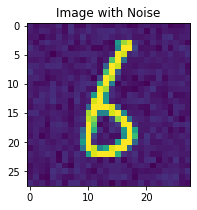

(1, 28, 28)


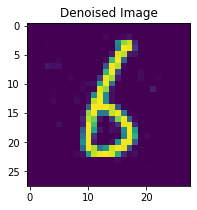

In [ ]:
fs = 3

def show_predictions(image):
  pred = model.predict(image)
  plt.figure(figsize=(fs,fs))
  plt.title('Denoised Image')
  den_img = array_to_img(pred[0])
  plt.imshow(den_img)
  plt.show()
  return den_img

plt.figure(figsize=(fs,fs))
plt.title('Image with Noise')
plt.imshow(x)
plt.show()
x = np.expand_dims(x, axis=0)
images = np.vstack([x])
print(images.shape)
den_img = show_predictions(images)
den_img= np.array(den_img)